# CME 241 (Winter 2021) - Assignment 14

## Question 1)

Implement LSTD algorithm.

In [1]:
import numpy as np
from numpy.typing import ArrayLike

from matplotlib import pyplot

In [2]:
# We try to approximate 5x^2 + 3x + 1

feature_funcs = [
    lambda z: np.square(z),
    lambda z: z,
    lambda z: np.ones(z.shape)
]

def f(x: ArrayLike, wgts: ArrayLike) -> float:
    """The function we would like to 'learn'."""
    x = x.reshape(-1, 1)
    matrix = np.hstack([ff(x) for ff in feature_funcs])
    fx = matrix @ wgts
    return fx

In [3]:
n = 500

wgts = np.array([5, 3, 1])

x = np.linspace(-5, 5, n)
exact = f(x, wgts) 
y = exact + 2 * np.random.randn(n)

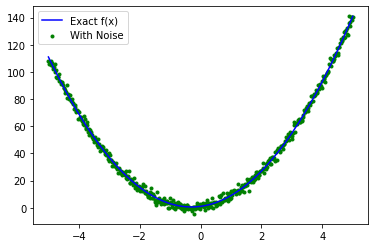

In [4]:
pyplot.plot(x, exact, label="Exact f(x)", color="b")
pyplot.scatter(x, y, label="With Noise", color="g",  marker=".")
pyplot.legend()
pyplot.show()

In [5]:
def recover_weights(x: ArrayLike, y: ArrayLike) -> ArrayLike:
    """Estime feature function weights."""
    x = x.reshape(-1, 1)
    m = np.hstack([ff(x) for ff in feature_funcs])
    w = np.linalg.pinv(m) @ y
    return w

In [6]:
estimated_params = recover_weights(x, y)
y_hat = f(x, estimated_params)

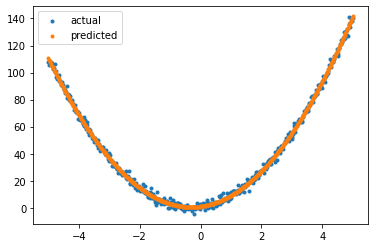

In [7]:
pyplot.scatter(x, y, label="actual", marker=".")
pyplot.scatter(x, y_hat, label="predicted", marker=".")
pyplot.legend()
pyplot.show()

None of that was RL, but cool exercise in function approximation nonetheless.

In [16]:
import itertools as it
from typing import List, Callable, TypeVar, Mapping, Tuple
import functools

from rl.chapter3.simple_inventory_mdp_cap import SimpleInventoryMDPCap, InventoryState
from rl.markov_decision_process import (
    TransitionStep, 
    FinitePolicy, 
    FiniteMarkovDecisionProcess as FiniteMDP
)
from rl.distribution import Constant, Choose
from rl.dynamic_programming import policy_iteration_result

In [17]:
S = TypeVar("S")
A = TypeVar("A")

def LSTDQ(
    *,
    D: List[TransitionStep], 
    features: List[Callable[[S, A], float]],
    gamma: float,
    pi: FinitePolicy
) -> ArrayLike:
    """Learn Q value basis weights for given policy."""
    k = len(features)
    A = 1e-5 * np.eye(k)
    b = np.zeros((k, 1))
    
    @functools.lru_cache
    def phi(state: S, action: A) -> float:
        """Apply the feature functions."""
        v = np.array([ff(state, action) for ff in features])
        return v.reshape(-1, 1)
    
    for step in D:
        s, a, r, s_ = step.state, step.action, step.reward, step.next_state
        a_ = pi.act(s_).sample()
        A += phi(s, a) @ (phi(s, a) - gamma * phi(s_, a_)).T
        b += r * phi(s, a)
        
    return np.linalg.pinv(A) @ b

In [18]:
@functools.lru_cache
def laguerre(x: float, k: int) -> float:
    """Compute kth Laguerre polynomial."""
    if k == 0:
        return 1.0
    if k == 1:
        return -x + 1
    prior = laguerre(x, k - 1)
    two_prior = laguerre(x, k - 2)
    return ((2 * k - 1 - x) * prior - (k - 1) * two_prior) / k

In [71]:
user_capacity = 2

mdp = SimpleInventoryMDPCap(
    capacity=user_capacity,
    poisson_lambda=1,
    holding_cost=1,
    stockout_cost=10,
)

fdp: FinitePolicy[InventoryState, int] = FinitePolicy({
    InventoryState(alpha, beta): 
    Choose({a for a in mdp.actions(InventoryState(alpha, beta))})
    for alpha in range(user_capacity + 1)
    for beta in range(user_capacity + 1 - alpha)
})
    
start_states = Choose({s for s in mdp.non_terminal_states})
traces = it.chain.from_iterable(mdp.action_traces(start_states, fdp))    

# Let's try some Laguerre polynomials
nested = [
    [
        lambda s, a: laguerre(s.on_hand, i),
        lambda s, a: laguerre(s.on_order, i),
        lambda s, a: laguerre(a, i)
    ] for i in range(5)
]
ffs = [ff for block in nested for ff in block]

In [72]:
def get_Q_values(
    mdp: FiniteMDP, wgts: ArrayLike
) -> Mapping[Tuple[S, A], float]:
    """Map state, action pairs to their estimated Q value."""
    mapping = {}
    for s in mdp.non_terminal_states:
        for a in mdp.actions(s):
            basis = np.vstack([ff(s, a) for ff in ffs])
            mapping[(s, a)] = wgts.T @ basis
    return mapping

In [73]:
gamma = 1.0

wgts = LSTDQ(
    D=list(it.islice(traces, 1000)),
    features=ffs,
    gamma=gamma,
    pi=fdp
)

Q = get_Q_values(mdp, wgts)
Q

{(InventoryState(on_hand=0, on_order=0), 0): array([[-31.97877849]]),
 (InventoryState(on_hand=0, on_order=0), 1): array([[-14.52715953]]),
 (InventoryState(on_hand=0, on_order=0), 2): array([[-24.81913994]]),
 (InventoryState(on_hand=0, on_order=1), 0): array([[-15.57772132]]),
 (InventoryState(on_hand=0, on_order=1), 1): array([[1.87389764]]),
 (InventoryState(on_hand=0, on_order=2), 0): array([[-25.25013965]]),
 (InventoryState(on_hand=1, on_order=0), 0): array([[-13.86593957]]),
 (InventoryState(on_hand=1, on_order=0), 1): array([[3.58567939]]),
 (InventoryState(on_hand=1, on_order=1), 0): array([[2.5351176]]),
 (InventoryState(on_hand=2, on_order=0), 0): array([[-24.54787021]])}

In [74]:
mrp = mdp.apply_finite_policy(fdp)
mrp.get_value_function_vec(gamma)

# not quite sure what's going on here...
# but we will move on and implement LSPI

array([-1.98453698e+17, -1.98453698e+17, -1.98453698e+17, -1.98453698e+17,
       -1.98453698e+17, -1.98453698e+17])

## Question 2)

Implement LSPI

In [75]:
def policy_from_weights(
    mdp: FiniteMDP, 
    wgts: ArrayLike,
    features: List[Callable[[S, A], float]],
) -> FinitePolicy:
    """Deterministic greedy policy from approximated values."""
    mapping = {}
    for s in mdp.non_terminal_states:
        choices = {}
        for a in mdp.actions(s):
            value = np.vstack([ff(s, a) for ff in features]).T @ wgts
            choices[float(value)] = a
        optimal_value = max(choices)
        optimal_choice = choices[optimal_value]
        mapping[s] = Constant(optimal_choice)
    return FinitePolicy(mapping)

def LSPI(
    *,
    mdp: FiniteMDP,
    D: List[TransitionStep], 
    features: List[Callable[[S, A], float]],
    gamma: float,
    tolerance: float = 1e-5
) -> ArrayLike:
    """Iteratively apply LSTDQ to find optimal policy."""
    wprev = np.ones(len(features))
    w = np.zeros(len(features))
    while np.linalg.norm(wprev - w) > tolerance:
        wprev = w
        pi = policy_from_weights(mdp, w, features)
        w = LSTDQ(D=D, features=features, gamma=gamma, pi=pi)
        
    return w

In [76]:
lspi_weights = LSPI(
    mdp=mdp,
    D=list(it.islice(traces, 1000)),
    features=ffs,
    gamma=gamma
)
lspi_policy = policy_from_weights(mdp, lspi_weights, ffs)

In [77]:
lspi_policy

For State InventoryState(on_hand=0, on_order=0):
  Do Action 1 with Probability 1.000
For State InventoryState(on_hand=0, on_order=1):
  Do Action 1 with Probability 1.000
For State InventoryState(on_hand=0, on_order=2):
  Do Action 0 with Probability 1.000
For State InventoryState(on_hand=1, on_order=0):
  Do Action 1 with Probability 1.000
For State InventoryState(on_hand=1, on_order=1):
  Do Action 0 with Probability 1.000
For State InventoryState(on_hand=2, on_order=0):
  Do Action 0 with Probability 1.000

In [ ]:
# There seems to be something wrong with the MDP, this doesn't converge
# but it matches the policy found in the simple_inventory_mdp_cap script

V, pol = policy_iteration_result(mdp, gamma)
pol